In [ ]:
import sys
import os
import math

from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from src.tools.google_drive import ensure_data_files

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go



mpl.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False
# 현재 파일이 있는 디렉토리 기준으로 상위 폴더 경로 추가
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # 한 단계 상위 폴더
sys.path.append(parent_dir)

print(f"추가된 경로: {parent_dir}")

data_paths = ensure_data_files()


추가된 경로: c:\Users\LEEYS\Desktop\쩝쩝LAB2\yamyam-lab
기존 data가 존재합니다. 파일 경로를 반환합니다.


In [47]:
data_paths

{'diner': 'C:\\Users\\LEEYS\\Desktop\\쩝쩝LAB2\\yamyam-lab\\data\\diner.csv',
 'category': 'C:\\Users\\LEEYS\\Desktop\\쩝쩝LAB2\\yamyam-lab\\data\\diner_category_raw.csv',
 'review': 'C:\\Users\\LEEYS\\Desktop\\쩝쩝LAB2\\yamyam-lab\\data\\review.csv',
 'reviewer': 'C:\\Users\\LEEYS\\Desktop\\쩝쩝LAB2\\yamyam-lab\\data\\reviewer.csv',
 'weather': 'C:\\Users\\LEEYS\\Desktop\\쩝쩝LAB2\\yamyam-lab\\data\\weather.csv'}

In [48]:
df_review = pd.read_csv(data_paths["review"], index_col=0)
df_diner = pd.read_csv(data_paths["diner"], index_col=0)
df_reviewer  = pd.read_csv(data_paths["reviewer"], index_col=0)
df_category = pd.read_csv(data_paths["category"], index_col=0)
df_weather = pd.read_csv(data_paths["weather"], encoding='euc-kr')

C:\Users\LEEYS\AppData\Local\Temp\ipykernel_26280\3064111770.py:2: DtypeWarning:

Columns (5,14) have mixed types. Specify dtype option on import or set low_memory=False.



In [49]:
print(f"데이터 추출: {len(df_review):,}")
print(f"데이터 추출: {len(df_diner):,}")
print(f"데이터 추출: {len(df_reviewer):,}")
print(f"데이터 추출: {len(df_category):,}")
print(f"데이터 추출: {len(df_weather):,}")


데이터 추출: 2,287,474
데이터 추출: 233,098
데이터 추출: 668,134
데이터 추출: 233,044
데이터 추출: 3,477


In [50]:
df = pd.merge(df_review, df_diner, on='diner_idx', how='left')
df = pd.merge(df, df_reviewer, on='reviewer_id', how='left')
df = pd.merge(df, df_category, on='diner_idx', how='left')

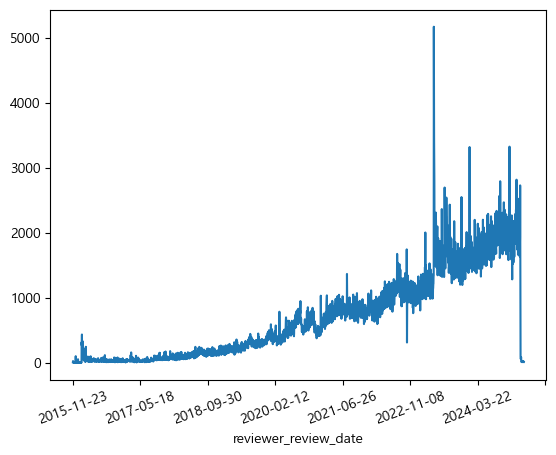

In [51]:
df.reviewer_review_date.value_counts().sort_index().plot()
plt.xticks(rotation=20)
plt.show()

In [52]:
df["reviewer_review_date"] = pd.to_datetime(df['reviewer_review_date'])
df['reviewer_review_weekday'] = df['reviewer_review_date'].dt.weekday


In [53]:
weekday_counts = df.reviewer_review_weekday.value_counts()
weekday_counts.sort_index(inplace=True)

In [54]:
weekday_map = {
    0: '월요일',
    1: '화요일',
    2: '수요일',
    3: '목요일',
    4: '금요일',
    5: '토요일',
    6: '일요일'
}
weekday_counts.index = weekday_counts.index.astype(int)
weekday_counts.index = weekday_counts.index.map(weekday_map)
weekday_counts


reviewer_review_weekday
월요일    310790
화요일    304761
수요일    310170
목요일    311443
금요일    317539
토요일    365277
일요일    367494
Name: count, dtype: int64

### 1. 요일 별 리뷰 수

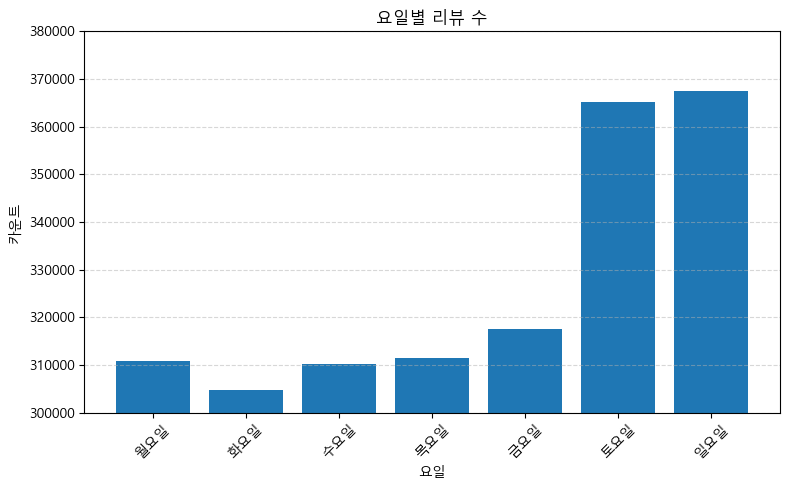

In [55]:
y_values = [weekday_counts[day] for day in weekday_map.values()]

plt.figure(figsize=(8, 5))
plt.bar(weekday_map.values(), y_values)
plt.title('요일별 리뷰 수')
plt.xlabel('요일')
plt.ylabel('카운트')
plt.xticks(rotation=45)
plt.ylim(300000, 380000)  
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### 2. 요일 별 리뷰수 (by 음식점 대분류)

In [56]:
group_by_weekday_n_cat = df.groupby(['reviewer_review_weekday', 'diner_category_large']).size().unstack(fill_value=0)
group_by_weekday_n_cat.index = group_by_weekday_n_cat.index.astype(int)
group_by_weekday_n_cat.index = group_by_weekday_n_cat.index.map(weekday_map)

In [57]:
fig = go.Figure()

for col in group_by_weekday_n_cat.columns:
    fig.add_trace(go.Scatter(
        x=group_by_weekday_n_cat.index,
        y=group_by_weekday_n_cat[col],
        mode='lines+markers',
        name=col
    ))

fig.update_layout(title='요일 별 리뷰 수(by 대분류)')

fig.show()

In [58]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
group_by_weekday_n_cat_scaled = pd.DataFrame(scaler.fit_transform(group_by_weekday_n_cat), columns=group_by_weekday_n_cat.columns, index=group_by_weekday_n_cat.index)

fig = go.Figure()

for col in group_by_weekday_n_cat_scaled.columns:
    fig.add_trace(go.Scatter(
        x=group_by_weekday_n_cat_scaled.index,
        y=group_by_weekday_n_cat_scaled[col],
        mode='lines+markers',
        name=col
    ))

fig.update_layout(title='요일 별 리뷰 수(by 대분류) MinMax Scaler 적용')
fig.show()

### 3. 요일별 리뷰 통계치 (by 대분류)

In [59]:
df['reviewer_review_weekday'] = df['reviewer_review_weekday'].map(weekday_map)

grouped_mean = df.groupby(['reviewer_review_weekday', 'diner_category_large'])['reviewer_review_score'].mean().unstack()
grouped_std = df.groupby(['reviewer_review_weekday', 'diner_category_large'])['reviewer_review_score'].std().unstack()
grouped_median = df.groupby(['reviewer_review_weekday', 'diner_category_large'])['reviewer_review_score'].median().unstack()
grouped_count = df.groupby(['reviewer_review_weekday', 'diner_category_large'])['reviewer_review_score'].count().unstack()

weekday_order = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
grouped_mean = grouped_mean.reindex(weekday_order)
grouped_std = grouped_std.reindex(weekday_order)
grouped_median = grouped_median.reindex(weekday_order)
grouped_count = grouped_count.reindex(weekday_order)

display(grouped_mean)

diner_category_large,간식,구내식당,기사식당,도시락,분식,뷔페,샐러드,샤브샤브,술집,식품판매,...,전문대행,중식,철판요리,치킨,카페,패밀리레스토랑,패스트푸드,푸드코트,퓨전요리,한식
reviewer_review_weekday,,,,,,,,,,,,,,,,,,,,,
월요일,3.899631,4.153846,3.582237,3.385621,3.588713,3.770810,4.069393,3.953975,4.068200,4.571429,...,3.0,3.771619,4.131148,3.609048,4.033449,3.533889,3.108228,2.537313,3.695024,3.955135
화요일,3.937993,3.747253,3.577778,3.406639,3.638922,3.774706,4.105814,4.015133,4.031562,4.466667,...,1.0,3.781626,4.203704,3.616364,4.068607,3.619423,3.112923,3.137500,3.729002,3.996791
수요일,3.957366,4.150000,3.609319,3.470238,3.622769,3.809851,4.087965,3.997575,4.092588,5.000000,...,5.0,3.818925,3.933884,3.587145,4.079051,3.607143,3.165810,3.138462,3.751613,3.967984
목요일,3.991930,3.890244,3.566929,3.427221,3.602605,3.834513,4.118343,3.973952,4.084649,3.461538,...,5.0,3.782806,4.302817,3.592606,4.093676,3.522373,3.111537,2.824561,3.835006,3.999851
금요일,3.961236,4.139535,3.698529,3.630397,3.627728,3.840243,4.108441,3.941315,4.072176,5.000000,...,NaN,3.800150,4.019231,3.591329,4.075422,3.239861,3.109766,2.750000,3.749422,3.996453
토요일,3.901655,3.813559,3.564179,3.469298,3.586534,3.672912,4.061798,3.907083,4.006918,4.428571,...,5.0,3.755670,3.755906,3.515132,3.973874,3.202521,3.049277,2.607595,3.603472,3.908093
일요일,3.838819,4.218182,3.628986,3.661836,3.520804,3.699889,3.983824,3.856927,4.006857,4.333333,...,5.0,3.690720,3.585034,3.445152,3.944968,3.227618,3.003319,2.903614,3.637801,3.831854


In [ ]:


def melt_df(df, value_name):
    return df.reset_index().melt(id_vars='reviewer_review_weekday', var_name='음식점_대분류', value_name=value_name)

df_mean = melt_df(grouped_mean, '평균')
df_std = melt_df(grouped_std, '표준편차')
df_median = melt_df(grouped_median, '중앙값')
df_count = melt_df(grouped_count, '리뷰 수')

fig = sp.make_subplots(
    rows=2, cols=2,
    subplot_titles=['평균 평점', '표준편차', '중앙값', '리뷰 수'],
    shared_xaxes=True
)

def add_trace(fig, df, row, col, y_name):
    for category in df['음식점_대분류'].unique():
        df_cat = df[df['음식점_대분류'] == category]
        fig.add_trace(
            go.Scatter(
                x=df_cat['reviewer_review_weekday'],
                y=df_cat[y_name],
                mode='lines+markers',
                name=category,
                legendgroup=category,
                showlegend=(row == 1 and col == 1) 
            ),
            row=row, col=col
        )

add_trace(fig, df_mean, 1, 1, '평균')
add_trace(fig, df_std, 1, 2, '표준편차')
add_trace(fig, df_median, 2, 1, '중앙값')
add_trace(fig, df_count, 2, 2, '리뷰 수')

fig.update_layout(height=700, width=1200, title_text='요일별 음식점 대분류별 평점 통계')
fig.show()


### 4. 분기 요일별 음식점 대분류 평균 평점

In [81]:
df['weekday_str'] = df['reviewer_review_weekday'].map(weekday_map)
df['Q'] = 'Q' + df['reviewer_review_date'].dt.quarter.astype(str)

summary = df.groupby(['Q', 'reviewer_review_weekday', 'diner_category_large']).agg({
    'review_id': 'count',
    'reviewer_review_score': ['mean', 'std', 'median']
}).reset_index()

summary.columns = ['Q', '요일', '카테고리', '리뷰수', '평균평점', '표준편차', '중앙값']
summary['요일'] = pd.Categorical(summary['요일'], categories=weekday_order, ordered=True)

fig = px.line(
    summary.sort_values('요일'),
    x='요일',
    y='평균평점',
    color='카테고리',
    facet_col='Q',
    title='분기별 요일별 음식점 대분류 평균 평점',
    markers=True,
    hover_data={
        '평균평점': True,
        '리뷰수': True,
        '표준편차': True,
        '중앙값': True,
        '카테고리': False,  
        '요일': False 
    },
    category_orders={'요일': weekday_order}
)

fig.update_layout(height=400, width=1500)
fig.show()


In [82]:
fig = px.bar(
    summary,
    x='Q',
    y='평균평점',
    color='카테고리',
    barmode='group',
    title='분기별 음식점 대분류 평균 평점',
    height=600,
    width=1000,
    hover_data={
    '평균평점': True,
    '리뷰수': True,
    '표준편차': True,
    '중앙값': True,
    '카테고리': False,  
    '요일': False 
},
)
fig.show()